In [25]:
!pip install -U langchain langgraph langchain-groq groq python-dotenv typing_extensions



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
from langchain_groq import ChatGroq


llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0)
resp = llm.invoke("Say 'Groq is working!'")
print(resp.content)


Groq is working!


In [27]:
from typing_extensions import TypedDict
class State(TypedDict):
  application: str
  experience_level: str
  skill_match : str
  response: str

In [28]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(State)

In [29]:
from langchain_core.prompts import ChatPromptTemplate

In [30]:
def categorize_experience(state: State) -> State:
  print("\nCategorizing the experience level of candidate : ")
  prompt = ChatPromptTemplate.from_template(
      "Based on the following job application, categorize the candidate as 'Entry-level', 'Mid-level' or 'Senior-level'"
      "Application : {application}"
  )
  chain = prompt | llm
  experience_level = chain.invoke({"application": state["application"]}).content
  print(f"Experience Level : {experience_level}")
  return {"experience_level" : experience_level}

def assess_skillset(state: State) -> State:
  print("\nAssessing the skillset of candidate : ")
  prompt = ChatPromptTemplate.from_template(
      "Based on the job application for a Python Developer, assess the candidate's skillset"
      "Respond with either 'Match' or 'No Match'"
      "Application : {application}"
  )
  chain = prompt | llm
  skill_match = chain.invoke({"application": state["application"]}).content
  print(f"Skill Match : {skill_match}")
  return {"skill_match" : skill_match}

def schedule_hr_interview(state: State) -> State:
  print("\nScheduling the interview : ")
  return {"response" : "Candidate has been shortlisted for an HR interview."}

def escalate_to_recruiter(state: State) -> State:
  print("Escalating to recruiter")
  return {"response" : "Candidate has senior-level experience but doesn't match job skills."}

def reject_application(state: State) -> State:
  print("Sending rejecting email")
  return {"response" : "Candidate doesn't meet JD and has been rejected."}

In [31]:
workflow.add_node("categorize_experience", categorize_experience)
workflow.add_node("assess_skillset", assess_skillset)
workflow.add_node("schedule_hr_interview", schedule_hr_interview)
workflow.add_node("escalate_to_recruiter", escalate_to_recruiter)
workflow.add_node("reject_application", reject_application)

In [32]:
def route_app(state: State) -> str:
    if state.get("skill_match") == "Match":
        return "schedule_hr_interview"
    elif state.get("experience_level") == "Senior-level":
        return "escalate_to_recruiter"
    else:
        return "reject_application"

# Edges
workflow.add_edge(START, "categorize_experience")
workflow.add_edge("categorize_experience", "assess_skillset")

#  Conditional edges
workflow.add_conditional_edges(
    "assess_skillset",
    route_app,
    {
        "schedule_hr_interview": "schedule_hr_interview",
        "escalate_to_recruiter": "escalate_to_recruiter",
        "reject_application": "reject_application",
    },
)

# Terminal edges
workflow.add_edge("schedule_hr_interview", END)
workflow.add_edge("escalate_to_recruiter", END)
workflow.add_edge("reject_application", END)


app = workflow.compile()


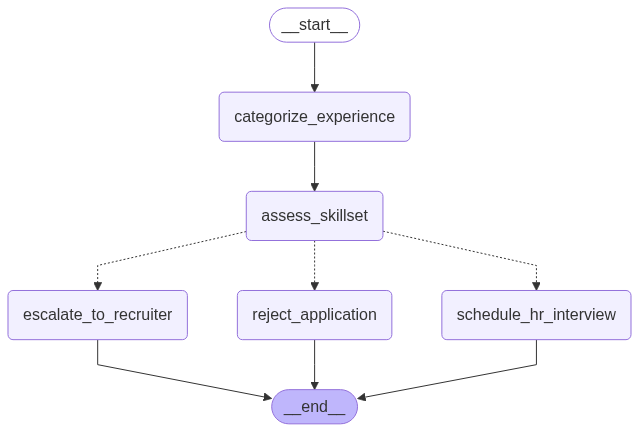

In [33]:
from IPython.display import Image, display

display(
    Image(
        app.get_graph().draw_mermaid_png()
    )
)

In [34]:
def run_candidate_screening(application: str):
  results = app.invoke({"application" : application})
  return {
      "experience_level" : results["experience_level"],
      "skill_match" : results["skill_match"],
      "response" : results["response"]
  }

In [35]:
application_text = "I have 10 years of experience in software engineering with expertise in JAVA"
results = run_candidate_screening(application_text)
print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


Categorizing the experience level of candidate : 
Experience Level : Based on the job application, I would categorize the candidate as 'Mid-level'. 

Here's the reasoning:

- The candidate has 10 years of experience, which is a significant amount of time in the field. This suggests that they have a good understanding of software engineering principles and have likely worked on multiple projects.
- The mention of "expertise in JAVA" implies that they have a strong foundation in a specific programming language, which is a key skill for a software engineer.
- However, the fact that they mention "10 years of experience" rather than "10 years of experience in leadership roles" or "10 years of experience in a senior position" suggests that they may not be at the most senior level of their career.

Overall, a mid-level candidate typically has 5-15 years of experience and has demonstrated a strong foundation in their field, but may not have reached the most senior levels of leadership or resp

In [36]:
application_text = "I have 1 year of experience in software engineering with expertise in JAVA"
results = run_candidate_screening(application_text)
print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


Categorizing the experience level of candidate : 
Experience Level : Based on the job application, I would categorize the candidate as 'Entry-level'. 

Here's why:

- The candidate has only 1 year of experience, which is typically considered a short period for a professional in the field.
- The candidate mentions expertise in JAVA, which is a common skill for entry-level software engineers to have.
- There is no mention of leadership roles, significant contributions to projects, or advanced technical skills that would typically be associated with mid-level or senior-level candidates.

Overall, the candidate's experience and skills suggest that they are at the beginning of their career in software engineering.

Assessing the skillset of candidate : 
Skill Match : No Match

The candidate has experience in software engineering, but their expertise is in Java, not Python. The job application is specifically for a Python Developer, so the candidate's skillset does not match the requirement

In [37]:
application_text = "I have experience in software engineering with expertise in Python"
results = run_candidate_screening(application_text)
print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


Categorizing the experience level of candidate : 
Experience Level : Based on the provided job application, I would categorize the candidate as 'Mid-level'. 

Here's my reasoning:

- The candidate mentions they have experience in software engineering, which suggests they have some level of experience and skills in the field.
- They also mention expertise in Python, which is a specific skill that is often acquired through experience and practice.
- However, there is no mention of leadership roles, significant achievements, or a long history of experience, which are often characteristics of senior-level candidates.
- The candidate's description does not indicate a complete beginner (entry-level), as they claim to have experience and expertise.

Therefore, 'Mid-level' seems to be the most fitting category for this candidate.

Assessing the skillset of candidate : 
Skill Match : Match

Scheduling the interview : 


Computed Results :
Application: I have experience in software engineering 

In [38]:
application_text = "I have 5 years of experience in software engineering with expertise in C++"
results = run_candidate_screening(application_text)
print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


Categorizing the experience level of candidate : 
Experience Level : Based on the job application, I would categorize the candidate as 'Mid-level'. 

Here's the reasoning:

- The candidate has 5 years of experience, which is more than the typical 1-3 years associated with entry-level positions.
- The candidate has expertise in C++, which suggests a level of specialization and proficiency in a specific area, but not necessarily leadership or high-level strategic responsibilities typically associated with senior-level positions.
- The candidate's experience and expertise are likely to be sufficient for a mid-level position, but may not be enough to qualify for a senior-level role, which often requires 8-12 years or more of experience and significant leadership or technical expertise.

Assessing the skillset of candidate : 
Skill Match : No Match

The candidate has experience in software engineering, but their expertise is in C++, which is not the primary language required for the Python